# Lab | Customer Analysis Round 5

For this lab, we still keep using the `marketing_customer_analysis.csv` file that you can find in the `files_for_lab` folder.


### 1. Get the data

We are using the `marketing_customer_analysis.csv` file.


In [26]:
#I import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [3]:
cd C:\Users\Dubun\IronHack\Other\jupyter_notebook

C:\Users\Dubun\IronHack\Other\jupyter_notebook


In [5]:
data=pd.read_csv('marketing_customer_analysis.csv')
data

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,LA72316,California,23405.987980,No,Basic,Bachelor,2/10/11,Employed,M,71941,...,89,0,2,Personal Auto,Personal L1,Offer2,Web,198.234764,Four-Door Car,Medsize
9130,PK87824,California,3096.511217,Yes,Extended,College,2/12/11,Employed,F,21604,...,28,0,1,Corporate Auto,Corporate L3,Offer1,Branch,379.200000,Four-Door Car,Medsize
9131,TD14365,California,8163.890428,No,Extended,Bachelor,2/6/11,Unemployed,M,0,...,37,3,2,Corporate Auto,Corporate L2,Offer1,Branch,790.784983,Four-Door Car,Medsize
9132,UP19263,California,7524.442436,No,Extended,College,2/3/11,Employed,M,21941,...,3,0,3,Personal Auto,Personal L2,Offer3,Branch,691.200000,Four-Door Car,Large


In [7]:
data.columns=data.columns.str.lower()
data.columns

Index(['customer', 'state', 'customer lifetime value', 'response', 'coverage',
       'education', 'effective to date', 'employmentstatus', 'gender',
       'income', 'location code', 'marital status', 'monthly premium auto',
       'months since last claim', 'months since policy inception',
       'number of open complaints', 'number of policies', 'policy type',
       'policy', 'renew offer type', 'sales channel', 'total claim amount',
       'vehicle class', 'vehicle size'],
      dtype='object')

In [8]:
data = data.rename(columns={'customer lifetime value':'customer_lifetime_value',
                           'effective to date':'effective_to_date',
                           'employmentstatus':'employment_status',
                           'location code':'location_code',
                           'marital status':'marital_status',
                           'monthly premium auto':'monthly_premium_auto',
                           'months since last claim':'months_since_last_claim',
                           'months since policy inception':'months_since_policy_inception',
                           'number of open complaints':'number_of_open_complaints',
                           'number of policies':'number_of_policies',
                           'policy type':'policy_type',
                           'renew offer type':'renew_offer_type',
                           'sales channel':'sales_channel',
                           'total claim amount':'total_claim_amount',
                           'vehicle class':'vehicle_class',
                           'vehicle size':'vehicle_size',
                           'vehicle type':'vehicle_type'})
data

,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employment_status,gender,income,...,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,LA72316,California,23405.987980,No,Basic,Bachelor,2/10/11,Employed,M,71941,...,89,0,2,Personal Auto,Personal L1,Offer2,Web,198.234764,Four-Door Car,Medsize
9130,PK87824,California,3096.511217,Yes,Extended,College,2/12/11,Employed,F,21604,...,28,0,1,Corporate Auto,Corporate L3,Offer1,Branch,379.200000,Four-Door Car,Medsize
9131,TD14365,California,8163.890428,No,Extended,Bachelor,2/6/11,Unemployed,M,0,...,37,3,2,Corporate Auto,Corporate L2,Offer1,Branch,790.784983,Four-Door Car,Medsize
9132,UP19263,California,7524.442436,No,Extended,College,2/3/11,Employed,M,21941,...,3,0,3,Personal Auto,Personal L2,Offer3,Branch,691.200000,Four-Door Car,Large



### 2. Dealing with the data

Already done in the round 2.



In [10]:
data = data.dropna()
data

,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employment_status,gender,income,...,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,LA72316,California,23405.987980,No,Basic,Bachelor,2/10/11,Employed,M,71941,...,89,0,2,Personal Auto,Personal L1,Offer2,Web,198.234764,Four-Door Car,Medsize
9130,PK87824,California,3096.511217,Yes,Extended,College,2/12/11,Employed,F,21604,...,28,0,1,Corporate Auto,Corporate L3,Offer1,Branch,379.200000,Four-Door Car,Medsize
9131,TD14365,California,8163.890428,No,Extended,Bachelor,2/6/11,Unemployed,M,0,...,37,3,2,Corporate Auto,Corporate L2,Offer1,Branch,790.784983,Four-Door Car,Medsize
9132,UP19263,California,7524.442436,No,Extended,College,2/3/11,Employed,M,21941,...,3,0,3,Personal Auto,Personal L2,Offer3,Branch,691.200000,Four-Door Car,Large


In [12]:
data.isna().sum()

customer                         0
state                            0
customer_lifetime_value          0
response                         0
coverage                         0
education                        0
effective_to_date                0
employment_status                0
gender                           0
income                           0
location_code                    0
marital_status                   0
monthly_premium_auto             0
months_since_last_claim          0
months_since_policy_inception    0
number_of_open_complaints        0
number_of_policies               0
policy_type                      0
policy                           0
renew_offer_type                 0
sales_channel                    0
total_claim_amount               0
vehicle_class                    0
vehicle_size                     0
dtype: int64

### 3. Explore the data

Some datasets have values that are missing, invalid, or otherwise difficult for an algorithm to process. If data is missing, the algorithm can’t use it. If data is invalid, the algorithm produces less accurate or even misleading outcomes. Some datasets are relatively clean but need to be shaped (e.g., aggregated or pivoted) and many datasets are just lacking useful business context (e.g., poorly defined ID values), hence the need for feature enrichment. Good data preparation produces clean and well-curated data which leads to more practical, accurate model outcomes.


   **3.1.- Determine the problems**
    
   **3.2.- Data cleaning** Cleaning the data is very important as the model learning from that data only, so if we feed inconsistent, appropriate data to model it will return garbage only, so it is required to make sure that the data does not contains any unseen problem.
     
       - Feature and Target Variables
       - Data Types
       - Missing data, check null values
       - Outliers
       - Duplicate data
        
   **3.3.- Feature selection** (Which variables are important to answer our questions?)
    
   **3.4.- Data transformation**

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer                       9134 non-null   object 
 1   state                          9134 non-null   object 
 2   customer_lifetime_value        9134 non-null   float64
 3   response                       9134 non-null   object 
 4   coverage                       9134 non-null   object 
 5   education                      9134 non-null   object 
 6   effective_to_date              9134 non-null   object 
 7   employment_status              9134 non-null   object 
 8   gender                         9134 non-null   object 
 9   income                         9134 non-null   int64  
 10  location_code                  9134 non-null   object 
 11  marital_status                 9134 non-null   object 
 12  monthly_premium_auto           9134 non-null   i

In [21]:
numerical = data.select_dtypes(include='number')
numerical

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
0,2763.519279,56274,69,32,5,0,1,384.811147
1,6979.535903,0,94,13,42,0,8,1131.464935
2,12887.431650,48767,108,18,38,0,2,566.472247
3,7645.861827,0,106,18,65,0,7,529.881344
4,2813.692575,43836,73,12,44,0,1,138.130879
...,...,...,...,...,...,...,...,...
9129,23405.987980,71941,73,18,89,0,2,198.234764
9130,3096.511217,21604,79,14,28,0,1,379.200000
9131,8163.890428,0,85,9,37,3,2,790.784983
9132,7524.442436,21941,96,34,3,0,3,691.200000


In [22]:
numerical.describe()

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


In [28]:
numerical_corr = numerical.corr()
numerical_corr #from the below correlation matrix, we can see that none of the features are highly correlated to one another (none of the correlations coeff are greater than 0.8)

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
customer_lifetime_value,1.000000,0.024366,0.396262,0.011517,0.009418,-0.036343,0.021955,0.226451
income,0.024366,1.000000,-0.016665,-0.026715,-0.000875,0.006408,-0.008656,-0.355254
monthly_premium_auto,0.396262,-0.016665,1.000000,0.005026,0.020257,-0.013122,-0.011233,0.632017
months_since_last_claim,0.011517,-0.026715,0.005026,1.000000,-0.042959,0.005354,0.009136,0.007563
months_since_policy_inception,0.009418,-0.000875,0.020257,-0.042959,1.000000,-0.001158,-0.013333,0.003335
number_of_open_complaints,-0.036343,0.006408,-0.013122,0.005354,-0.001158,1.000000,0.001498,-0.014241
number_of_policies,0.021955,-0.008656,-0.011233,0.009136,-0.013333,0.001498,1.000000,-0.002354
total_claim_amount,0.226451,-0.355254,0.632017,0.007563,0.003335,-0.014241,-0.002354,1.000000


In [29]:
X = numerical.drop(['total_claim_amount'], axis=1)
y = numerical['total_claim_amount']

# with 'add_constant' we force the model to have an intercept
X = sm.add_constant(X)

model = sm.OLS(y,X).fit() # to train the model

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     1405.
Date:                Fri, 11 Jun 2021   Prob (F-statistic):               0.00
Time:                        10:50:25   Log-Likelihood:                -61425.
No. Observations:                9134   AIC:                         1.229e+05
Df Residuals:                    9126   BIC:                         1.229e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [41]:
#In the above Regression model, we can see that adj. r squared is quite high, but we can make it better if we drop features showing p-values > 0.05
#--> months_since_last_claim, months_since_policy_inception, number_of_open_complaints, number_of_policies
regression_dropped = numerical.drop(['months_since_last_claim', 'months_since_policy_inception', 'number_of_open_complaints','number_of_policies'], axis=1)
regression_dropped.columns

Index(['customer_lifetime_value', 'income', 'monthly_premium_auto',
       'total_claim_amount'],
      dtype='object')

In [43]:
X2 = regression_dropped.drop(['total_claim_amount'], axis=1)
y2 = regression_dropped['total_claim_amount']

# with 'add_constant' we force the model to have an intercept
X2 = sm.add_constant(X2)

model2 = sm.OLS(y2,X2).fit() # to train the model

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     3277.
Date:                Fri, 11 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:06:27   Log-Likelihood:                -61427.
No. Observations:                9134   AIC:                         1.229e+05
Df Residuals:                    9130   BIC:                         1.229e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

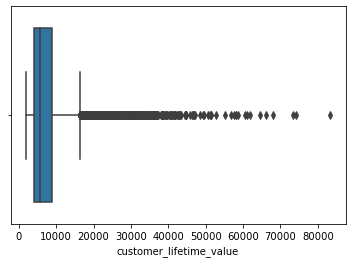

In [45]:
#now we will show boxplots for features to check for outliers
sns.boxplot(x=data['customer_lifetime_value'])
plt.show()

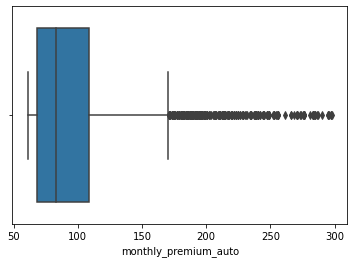

In [48]:
sns.boxplot(x=data['monthly_premium_auto'])
plt.show()

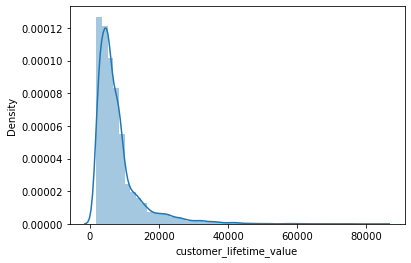

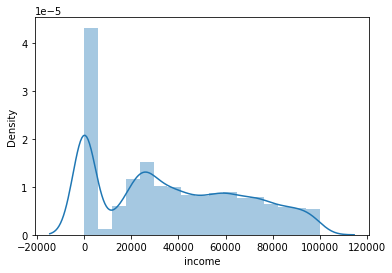

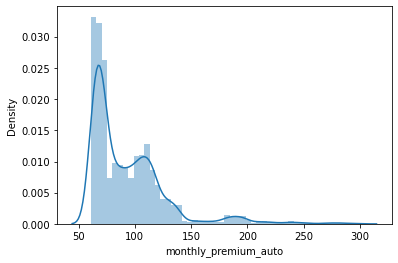

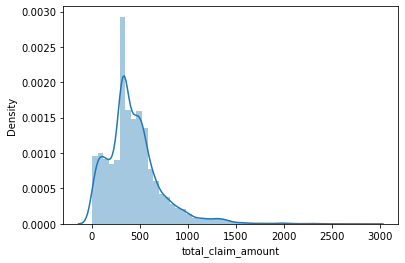

In [50]:
#let's check the distribution of our data
for column in regression_dropped.columns:
    sns.distplot(regression_dropped[column])
    plt.show()
#none of the features are normally distributed --> we will then transform and normalize the features.

In [52]:
import pickle

In [54]:
y3 = regression_dropped['total_claim_amount']
X3 = regression_dropped.drop(['total_claim_amount'], axis=1)

In [56]:
X_num = X3.select_dtypes(include = np.number)
X_cat = X3.select_dtypes(include = np.object)

In [58]:
# Normalizing data
transformer = Normalizer() # Normalizer works column wise, so don't use it on the target 
# (X-y split comes first, or else your features will carry information from the target)
transformer.fit(X_num) # you'll always only fit on the trainning data

# When Normalizing with encoded categorical data, you'll lose some information on the categories.
# When Normalizing only numericals, you'll be losing proportion between numericals and encoded categories.

with open('transformer.pkl', 'wb') as file:
    pickle.dump(transformer, file)

with open('transformer.pkl', 'rb') as file:
    transformer = pickle.load(file)

x_normalized = transformer.transform(X_num)
#pd.DataFrame(x_normalized)
x_normalized.shape

(9134, 3)

In [64]:
pd.DataFrame(x_normalized)

,0,1,2
0,0.049049,0.998796,0.001225
1,0.999909,0.000000,0.013467
2,0.255494,0.966808,0.002141
3,0.999904,0.000000,0.013862
4,0.064055,0.997945,0.001662
...,...,...,...
9129,0.309387,0.950936,0.000965
9130,0.141880,0.989877,0.003620
9131,0.999946,0.000000,0.010411
9132,0.324392,0.945914,0.004139


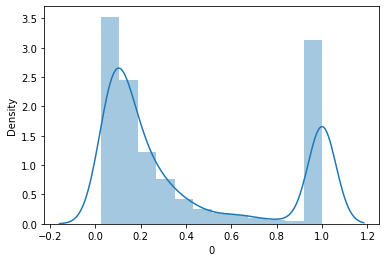

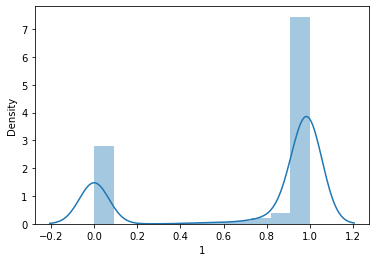

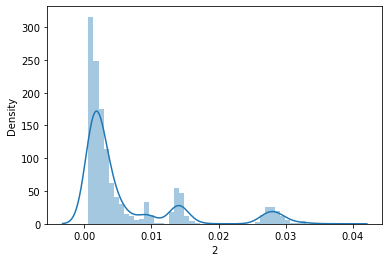

In [66]:
#let's check the distribution of our data
for column in pd.DataFrame(x_normalized).columns:
    sns.distplot(pd.DataFrame(x_normalized)[column])
    plt.show()
#as we can see in the below graphs, the features are still not normally distributed. What have I done wrong ? I thought this transformation 
#method was eliminating outliers, but it doesn't look like to. I should have replaced them by the feature mean right ? And then it would have been normally distributed ?

### 4. Processing Data

(_Further processing..._)

- X-y split.
- Normalize (numerical).